In [103]:
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import pickle
import os
import json
from tqdm import tqdm
from IPython import display
from copy import deepcopy

# 1. Loading CIFAR10 data

In [ ]:
# Downloading and unpacking cifar-10
! wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
! tar -xf cifar-10-python.tar.gz 
! rm cifar-10-python.tar.gz

In [1]:
def load_CIFAR10_batch(filepath):
    with open(filepath, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        features = batch[b'data'].astype('float')
        labels = batch[b'labels']
        labels = np.array(labels)
        return features, labels

def load_CIFAR10(cifar_path, batches_num=6):
    X_train = []
    Y_train = []
    for batch in range(1, batches_num):
        file = os.path.join(cifar_path, 'data_batch_{}'.format(batch))
        features, labels = load_CIFAR10_batch(file)
        X_train.append(features)
        Y_train.append(labels)
    X_train = np.concatenate(X_train)
    Y_train = np.concatenate(Y_train)
    X_test, Y_test = load_CIFAR10_batch(os.path.join(cifar_path, 'test_batch'))
    return X_train, Y_train, X_test, Y_test

In [218]:
CIFAR_PATH = './cifar-10-batches-py'
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig = load_CIFAR10(CIFAR_PATH)
print('Train samples num: ', len(Y_train))
print('Test samples num: ', len(Y_test))

Train samples num:  100
Test samples num:  100


Lets take a small part of the original dataset for our experiments.

In [87]:
def get_balanced_data(x, y, size, labels=np.arange(0, 10)):
    result_x = np.array([]).reshape([0, 3072])
    result_y = np.array([])
    for label in labels:
        label_indices = np.where(y == label)[0][0:size]
        result_x = np.concatenate([result_x, x[label_indices]])
        result_y = np.concatenate([result_y, y[label_indices]])
    
    return result_x, result_y.astype(np.uint8)

In [117]:
CLASSES_NUM = 10
SAMPLE_SIZE = 100

X_val, Y_val = get_balanced_data(X_train_orig[0:1000], Y_train_orig[0:1000], size=SAMPLE_SIZE // CLASSES_NUM)
X_train, Y_train = get_balanced_data(X_train_orig[1000:], Y_train_orig[1000:], size=SAMPLE_SIZE // CLASSES_NUM)
X_test, Y_test = get_balanced_data(X_test_orig, Y_test_orig, size=SAMPLE_SIZE // CLASSES_NUM)

Let's make sure that the labels inside the datasets are uniformly distributed:

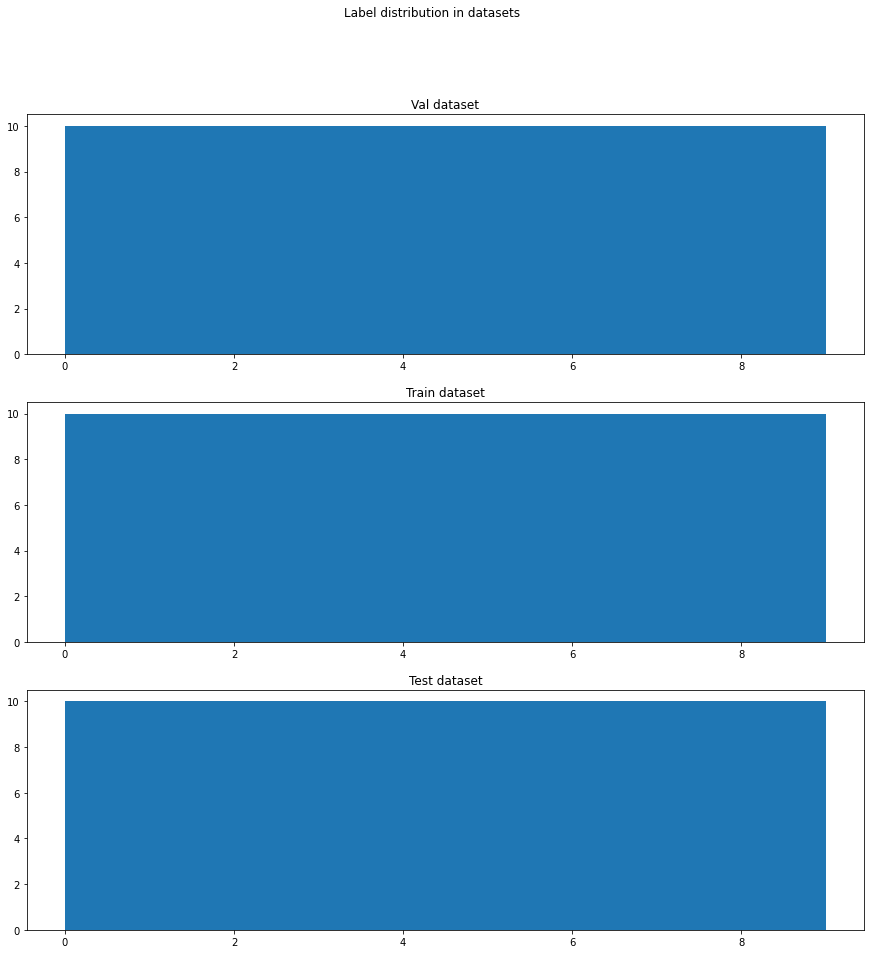

In [118]:
fig, axs = plt.subplots(3, figsize=(15, 15))
fig.suptitle('Label distribution in datasets')
axs[0].hist(Y_val)
axs[0].set_title('Val dataset')

axs[1].hist(Y_train)
axs[1].set_title('Train dataset')

axs[2].hist(Y_test)
axs[2].set_title('Test dataset')

plt.show()

Lets implement Dataset and Dataloader classes, similar to Pytorch.

In [135]:
class Dataset:
    """
        An abstract class representing a :class:`Dataset`
    """
    
    def __getitem__(self, index: int):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

class Dataloader:
    """
        An abstract class representing a :class:'Dataloader'
    """
    def __iter__(self):
        return self

    def __next__(self):
        return NotImplementedError

class Cifar10Dataset(Dataset):
    def __init__(self, cifar_features, cifar_labels, normalize=True, one_hot=True):
        super().__init__()
        if normalize:
            self.features = cifar_features / 255.0
        else:
            self.features = cifar_features
        if one_hot:
            self.labels = np.zeros((cifar_labels.size, cifar_labels.max() + 1))
            self.labels[np.arange(cifar_labels.size), cifar_labels] = 1
        else:
            self.labels = cifar_labels
    
    def __getitem__(self, index: int):
        return self.features[index], self.labels[index]

    def __len__(self):
        return len(self.labels)

class CifarDataloader(Dataloader):
    def __init__(self, dataset, batch_size) -> None:
        super().__init__()
        self.dataset = dataset
        self.batch_size = batch_size
        self.curr_index = 0
    
    def __next__(self):
        if self.curr_index < len(self.dataset):
            self.curr_index += self.batch_size
            return self.dataset[self.curr_index - self.batch_size: min(self.curr_index, len(self.dataset))]
        else:
            self.reset()
            raise StopIteration()
    
    def reset(self):
        self.curr_index = 0

    def __len__(self):
        return len(self.dataset) // self.batch_size

Creating $\textbf{Datasets}$ and $\textbf{Dataloaders}$:

In [136]:
BATCH_SIZE = 10
train_dataset = Cifar10Dataset(X_train, Y_train)
val_dataset = Cifar10Dataset(X_val, Y_val)
test_dataset = Cifar10Dataset(X_test, Y_test)

train_dataloader = CifarDataloader(train_dataset, BATCH_SIZE)
val_dataloader = CifarDataloader(val_dataset, BATCH_SIZE)
test_dataloader = CifarDataloader(test_dataset, batch_size=len(test_dataset))

# 2. Testing different models
### a) In this part, I will train several Linear models with three hidden layers and various activation functions: Real, LeakyReLU, ELU, SoftMax, Sigmoid, Tanh.

Firstly, lets implement all the necessary modules and criterions using Pytorch semantics.

In [126]:
# Module is an abstract class which defines fundamental methods necessary for a training a neural network. You do not need to change anything here, just read the comments.
class Module(object):
    """
    Basically, you can think of a module as of a something (black box) 
    which can process `input_` data and produce `ouput` data.
    This is like applying a function which is called `forward`: 
        
        output = module.forward(input_)
    
    The module should be able to perform a backward pass: to differentiate the `forward` function. 
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule. 
    
        gradInput = module.backward(input_, gradOutput)
    """
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True
    
    def forward(self, input_):
        """
        Takes an input_ object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input_)

    def backward(self,input_, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input_.
        
        This includes 
         - computing a gradient w.r.t. `input_` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self.updateGradInput(input_, gradOutput)
        self.accGradParameters(input_, gradOutput)
        return self.gradInput
    

    def updateOutput(self, input_):
        """
        Computes the output using the current parameter set of the class and input_.
        This function returns the result which is stored in the `output` field.
        
        Make sure to both store the data in `output` field and return it. 
        """
        pass

    def updateGradInput(self, input_, gradOutput):
        """
        Computing the gradient of the module with respect to its own input_. 
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.
        
        The shape of `gradInput` is always the same as the shape of `input_`.
        
        Make sure to both store the gradients in `gradInput` field and return it.
        """
        pass   
    
    def accGradParameters(self, input_, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass
    
    def zeroGradParameters(self): 
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass
        
    def getParameters(self):
        """
        Returns a list with its parameters. 
        If the module does not have parameters return empty list. 
        """
        return []
        
    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters. 
        If the module does not have parameters return empty list. 
        """
        return []
    
    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True
    
    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False
    
    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want 
        to have readable description. 
        """
        return "Module"

Lets implement Sequential container.

In [127]:
class Sequential(Module):
    """
         This class implements a container, which processes `input_` data sequentially. 
         
         `input_` is processed by each module (layer) in self.modules consecutively.
         The resulting array is called `output`. 
    """
    
    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []
   
    def add(self, module):
        """
        Adds a module to the container.
        """
        self.modules.append(module)

    def updateOutput(self, input_):
        """
        Basic workflow of FORWARD PASS:
        
            y_0    = module[0].forward(input_)
            y_1    = module[1].forward(y_0)
            ...
            output = module[n-1].forward(y_{n-2})   
            
            
        Just write a little loop. 
        """

        self.output = input_

        for module in self.modules:
            self.output = module.forward(self.output)

        return self.output

    def backward(self, input_, gradOutput):
        """
        Workflow of BACKWARD PASS:
            
            g_{n-1} = module[n-1].backward(y_{n-2}, gradOutput)
            g_{n-2} = module[n-2].backward(y_{n-3}, g_{n-1})
            ...
            g_1 = module[1].backward(y_0, g_2)   
            gradInput = module[0].backward(input_, g_1)   
             
             
        !!!
                
        To ech module you need to provide the input_, module saw while forward pass, 
        it is used while computing gradients. 
        Make sure that the input_ for `i-th` layer the output of `module[i]` (just the same input_ as in forward pass) 
        and NOT `input_` to this Sequential module. 
        
        !!!
        
        """
        for i in range(len(self.modules)-1, 0, -1):
            gradOutput = self.modules[i].backward(self.modules[i-1].output, gradOutput)

        self.gradInput = self.modules[0].backward(input_, gradOutput)

        return self.gradInput
      

    def zeroGradParameters(self): 
        for module in self.modules:
            module.zeroGradParameters()
    
    def getParameters(self):
        """
        Should gather all parameters in a list.
        """
        return [x.getParameters() for x in self.modules]
    
    def getGradParameters(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        return [x.getGradParameters() for x in self.modules]
    
    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string
    
    def __getitem__(self,x):
        return self.modules.__getitem__(x)
    
    def train(self):
        """
        Propagates training parameter through all modules
        """
        self.training = True
        for module in self.modules:
            module.train()
    
    def evaluate(self):
        """
        Propagates training parameter through all modules
        """
        self.training = False
        for module in self.modules:
            module.evaluate()

And lets implement all the necessary layers and activations:

In [304]:
# Linear transform layer
class Linear(Module):
    """
    A module which applies a linear transformation 
    A common name is fully-connected layer, InnerProductLayer in caffe. 
    
    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
       
        np.random.seed(42)
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)
        
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def updateOutput(self, input):
        self.output = input @ self.W.T + self.b
        return self.output
    
    def updateGradInput(self, input, gradOutput):        
        self.gradInput = np.zeros_like(input)
        np.matmul(gradOutput, self.W.astype(input.dtype), out=self.gradInput)
        return self.gradInput
    
    def accGradParameters(self, input, gradOutput):
        self.gradW = gradOutput.T @ input
        self.gradb = gradOutput.sum(axis=0)
        
        pass
    
    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)
        
    def getParameters(self):
        return [self.W, self.b]
    
    def getGradParameters(self):
        return [self.gradW, self.gradb]
    
    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

# SoftMax
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()
    
    def updateOutput(self, input_):
        # start with normalization for numerical stability
        self.output = np.subtract(input_, input_.max(axis=1, keepdims=True))
        
        self.output = np.exp(self.output)
        self.output = self.output / np.sum(self.output, axis=1, keepdims=True)
        
        return self.output
    
    def updateGradInput(self, input_, gradOutput):
        local_repr_1 = np.einsum('bi,bj->bij', self.output, self.output)
        local_repr_2 = np.einsum(
            'bi,ij->bij',
            self.output,
            np.eye(input_.shape[1], input_.shape[1])
        )
        local_repr_3 = local_repr_2 - local_repr_1
        
        self.gradInput = np.einsum('bij,bi->bj', local_repr_3, gradOutput)
        return self.gradInput
    
    def __repr__(self):
        return "SoftMax"

# Batch normalization
class BatchNormalization(Module):
    EPS = 1e-3
    def __init__(self, alpha = 0.):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = 0
        self.moving_variance = 0
        
    def updateOutput(self, input):
        self.output = np.zeros_like(input)
        if self.training == True:
            self.batch_mean = input.mean(axis=0)
            
            self.batch_var = input.var(axis=0)
            self.moving_mean = self.moving_mean * self.alpha + self.batch_mean * (1 - self.alpha)
            self.moving_variance = self.moving_variance * self.alpha + self.batch_var * (1 - self.alpha)
            self.output = np.subtract(input, self.batch_mean) / np.sqrt(self.batch_var + self.EPS)
        else:
            self.output = np.subtract(input, self.moving_mean) / np.sqrt(self.moving_variance + self.EPS)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.zeros_like(input)
        normalized = np.zeros_like(input)
        normalized = np.subtract(input,self.batch_mean) / (np.sqrt(np.add(self.batch_var,self.EPS)))
        np.multiply(np.divide(1,np.multiply(np.sqrt(np.add(self.batch_var,self.EPS)), input.shape[0])),np.subtract(np.subtract(np.multiply(input.shape[0],gradOutput),gradOutput.sum(axis=0)),np.multiply(normalized,np.sum(np.multiply(gradOutput,normalized), axis=0))), out = self.gradInput)
        return self.gradInput
    
    def __repr__(self):
        return "BatchNormalization"

# Dropout
class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        
        self.p = p
        self.mask = None
        
    def updateOutput(self, input):
        if not self.training:
            self.output = input
        else:
            self.mask = np.random.binomial(1, 1. - self.p, input.shape)
            self.output = np.multiply(input, self.mask)
            self.output /= 1. - self.p
        return  self.output
    
    def updateGradInput(self, input, gradOutput):
        if not self.training:
            self.gradInput = gradOutput
        else:
            self.gradInput = np.multiply(gradOutput, self.mask)
            self.gradInput /= (1. - self.p)
        return self.gradInput
        
    def __repr__(self):
        return "Dropout"

# ReLU
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()
    
    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput , input > 0)
        return self.gradInput
    
    def __repr__(self):
        return "ReLU"

# Leaky ReLU
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()
            
        self.slope = slope
        
    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        self.output -= self.slope * np.maximum(-input, 0)
        return  self.output
    
    def updateGradInput(self, input, gradOutput):
        mask_positive, mask_negative = input >= 0, input < 0
        self.gradInput = gradOutput*(mask_positive + mask_negative * self.slope) 
        return self.gradInput
    
    def __repr__(self):
        return "LeakyReLU"

# ELU
class ELU(Module):
    def __init__(self, alpha = 1.0):
        super(ELU, self).__init__()
        
        self.alpha = alpha
        
    def updateOutput(self, input):
        self.output = input.copy()
        self.output[self.output < 0] = (np.exp(self.output[self.output < 0])-1)*self.alpha
        return  self.output
    
    def updateGradInput(self, input, gradOutput):
        mask_positive, mask_negative = input >= 0, input < 0
        self.gradInput = gradOutput * (mask_positive + np.exp(input)*mask_negative*self.alpha)
        return self.gradInput
    
    def __repr__(self):
        return "ELU"

# SoftPlus
class SoftPlus(Module):
    def __init__(self):
        super(SoftPlus, self).__init__()
    
    def updateOutput(self, input):
        self.output = np.log(1 + np.exp(input))
        return  self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.divide(gradOutput, (np.exp(-input)+1))
        return self.gradInput
    
    def __repr__(self):
        return "SoftPlus"

# Sigmoid
class Sigmoid(Module):
    def __init__(self):
        super().__init__()

    def updateOutput(self, input):
        self.output = 1 / (1 + np.exp(-input))
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(np.multiply(gradOutput, self.output), 1-self.output)
        return self.gradInput

    def __repr__(self):
        return "Sigmoid"

# Tanh
class Tanh(Module):
    def __init__(self):
        super().__init__()
    
    def updateOutput(self, input):
        self.output = np.tanh(input)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput, 1 / (np.cosh(input)**2))
        return self.gradInput

    def __repr__(self):
        return 'Tanh'

class Swish(Module):
    def __init__(self):
        super().__init__()
    
    def updateOutput(self, input):
        self.output = np.multiply(input, 1 / (1 + np.exp(-input)))
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput, self.output + np.multiply(1 / (1 + np.exp(-input)), (1 - self.output)))
        return self.gradInput

    def __repr__(self):
        return 'Swish'

Now it's criterions turn to be implemented.

In [129]:
# Criterion base class
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None
        
    def forward(self, input, target):
        """
            Given an input and a target, compute the loss function 
            associated to the criterion and return the result.
            
            For consistency this function should not be overrided,
            all the code goes in `updateOutput`.
        """
        return self.updateOutput(input, target)

    def backward(self, input, target):
        """
            Given an input and a target, compute the gradients of the loss function
            associated to the criterion and return the result. 

            For consistency this function should not be overrided,
            all the code goes in `updateGradInput`.
        """
        return self.updateGradInput(input, target)
    
    def updateOutput(self, input, target):
        """
        Function to override.
        """
        return self.output

    def updateGradInput(self, input, target):
        """
        Function to override.
        """
        return self.gradInput   

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want 
        to have readable description. 
        """
        return "Criterion"
        

# Negative LogLokelihood criterion
class ClassNLLCriterion(Criterion):
    def __init__(self):
        super().__init__()
        
    def updateOutput(self, input, target): 
        self.output = -np.sum(np.multiply(target, input)) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput = -target / input.shape[0]
        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterion"


# Hinge Loss
class HingeLoss(Criterion):
    """
    Crammer and Singer Hinge loss definition for multiclass task
    """
    def __init__(self):
        super().__init__()
        self.not_aggregated_output = None

    def updateOutput(self, input, target):
        false_margins = np.max(np.multiply(input, (1-target)), axis=1)
        true_margins = np.max(np.multiply(input, target), axis=1)
        res = np.maximum(np.ones_like(false_margins) + false_margins - true_margins, np.zeros_like(false_margins))
        self.not_aggregated_output = (res > 0).astype(np.float64)
        self.output = np.sum(res) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        drop_if_not_max = lambda x: (x >= np.max(x)).astype(np.float64)
        res = - target.astype(np.float64)
        res += np.apply_along_axis(drop_if_not_max, 1, np.multiply(input, (1-target)))
        res = np.diag(self.not_aggregated_output) @ res
        self.gradInput = res / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return 'HingeLoss'

And now... Optimizers! 

With L1, L2 regularizations, of course.

In [130]:
def apply_regularization(variables, grads, regularization, coef):
    """
        Add additional gradients due to regularization ('l2', 'l1')
        `variables` - list of lists of variables (one list per layer)
        `gradients` - list of lists of current gradients (same structure as for `variables`, one array for each var)
        `regularization` - regularization type: l1 or l2
        `coef` - regularization coef
    """
    if regularization is None:
        return

    if regularization.lower() == 'l2':
        np.add(grads, coef * 2 * variables, grads)
                
    elif regularization.lower() == 'l1':
        mask = (variables > 0).astype(variables.dtype) - (variables < 0).astype(variables.dtype)
        np.add(grads, coef * mask, grads)



# SGD optimizer with momentum
def sgm_momentum(variables, gradients, config, state, regularization=None, coef=1e-4):
    """
        `variables` - list of lists of variables (one list per layer)
        `gradients` - list of lists of current gradients (same structure as for `variables`, one array for each var)
        `config` - dict with optimization parameters (`learning_rate` and `momentum`)
        `state` - dict with optimizator state (used to save accumulated gradients)
    """
    state.setdefault('accumulated_grads', {})
    
    var_index = 0 
    for current_layer_vars, current_layer_grads in zip(variables, gradients): 
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            apply_regularization(current_var, current_grad, regularization, coef)
            
            old_grad = state['accumulated_grads'].setdefault(var_index, np.zeros_like(current_grad))
            
            np.add(config['momentum'] * old_grad, config['learning_rate'] * current_grad, out=old_grad)            
            current_var -= old_grad
            var_index += 1  

# Adam optimizer (https://arxiv.org/pdf/1412.6980.pdf)
def adam_optimizer(variables, gradients, config, state, regularization=None, coef=1e-4):  
    """
        `variables` - list of lists of variables (one list per layer)
        `gradients` - list of lists of current gradients (same structure as for `variables`, one array for each var)
        `config` - dict with optimization parameters (`learning_rate`, `beta1`, `beta2`, `epsilon`)
        `state` - dict with optimizator state (used to save 1st and 2nd moment for vars)
          
        Formulas for optimizer:
          
        Current step learning rate: $$\text{lr}_t = \text{learning_rate} * \frac{\sqrt{1-\beta_2^t}} {1-\beta_1^t}$$
        First moment of var: $$\mu_t = \beta_1 * \mu_{t-1} + (1 - \beta_1)*g$$ 
        Second moment of var: $$v_t = \beta_2 * v_{t-1} + (1 - \beta_2)*g*g$$
        New values of var: $$\text{variable} = \text{variable} - \text{lr}_t * \frac{m_t}{\sqrt{v_t} + \epsilon}$$
    """
    state.setdefault('m', {})  # first moment vars
    state.setdefault('v', {})  # second moment vars
    state.setdefault('t', 0)   # timestamp
    state['t'] += 1
    for k in ['learning_rate', 'beta1', 'beta2', 'epsilon']:
        assert k in config, config.keys()
    
    var_index = 0 
    lr_t = config['learning_rate'] * np.sqrt(1 - config['beta2']**state['t']) / (1 - config['beta1']**state['t'])
    for current_layer_vars, current_layer_grads in zip(variables, gradients): 
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            apply_regularization(current_var, current_grad, regularization, coef)
            var_first_moment = state['m'].setdefault(var_index, np.zeros_like(current_grad))
            var_second_moment = state['v'].setdefault(var_index, np.zeros_like(current_grad))
            np.add(config['beta1'] * var_first_moment, (1-config['beta1']) * current_grad , out = var_first_moment)
            np.add(config['beta2'] * var_second_moment, (1-config['beta2']) * current_grad * current_grad, out = var_second_moment)
            current_var -= lr_t * var_first_moment / np.sqrt((var_second_moment) + config['epsilon'])
            
            assert var_first_moment is state['m'].get(var_index)
            assert var_second_moment is state['v'].get(var_index)
            var_index += 1

And, finally we need to write the training cycle.

In [148]:
def mean_weights_grads_ratio_norm(model):
    weight_norms = []
    grad_norms = []
    for module_weights, module_grads in zip(model.getParameters(), model.getGradParameters()):
        for parameter, parameter_grad in zip(module_weights, module_grads):
            weight_norms.append(np.linalg.norm(parameter))
            grad_norms.append(np.linalg.norm(parameter_grad))

    return np.mean(np.array(grad_norms) / np.array(weight_norms))

def train(
    model, criterion, optimizer, optimizer_config, train_dataloader,
    val_dataloader=None, test_dataloader=None, epoch_num=10, reg_coef=None,
    optimizer_state=None, logging=False, model_name='model', regularization=None,
    log_dir='/home/ivainn/Alex/DL_homeworks/logs', log_name='log.json', epoch_lrs=None
    ):

    if optimizer_state is None:
        optimizer_state = {}
    train_loss_history = []
    train_accuracy_history = []
    train_grad_norm_history = []
    val_loss_history = []
    val_accuracy_history = []
    test_loss = 0
    test_accuracy = 0

    for epoch in tqdm(range(epoch_num)):
        display.clear_output(wait=True)
        # Training
        if epoch_lrs is not None:
            optimizer_state['learning_rate'] = epoch_lrs[epoch]

        model.train()
        for x_batch, y_batch in train_dataloader:            
            model.zeroGradParameters()

            # Forward
            predictions = model.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            model.backward(x_batch, dp)

            # Update weights
            optimizer(
                model.getParameters(), 
                model.getGradParameters(), 
                optimizer_config,
                optimizer_state,
                regularization,
                reg_coef
                )  

            # Update history
            accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_batch, axis=1))/y_batch.shape[0]
            train_accuracy_history.append(accuracy)
            train_loss_history.append(loss)
            train_grad_norm_history.append(optimizer_config['learning_rate'] * np.mean(mean_weights_grads_ratio_norm(model)))    
        
        # Evaluation
        if val_dataloader is None:
            continue

        model.evaluate()
        samples_num = 0
        loss = 0
        correct_predictions = 0
        batches_num = 0
        for x_batch, y_batch in val_dataloader:
            samples_num += x_batch.shape[0]
            batches_num += 1

            predictions = model.forward(x_batch)
            loss += np.sum(criterion.forward(predictions, y_batch))
            correct_predictions += np.sum(np.argmax(predictions, axis=1) == np.argmax(y_batch, axis=1))
        val_loss_history.append(loss / batches_num)
        val_accuracy_history.append(correct_predictions / samples_num)

    if test_dataloader is not None:
        model.evaluate()
        samples_num = 0
        loss = 0
        correct_predictions = 0
        for x_batch, y_batch in test_dataloader:
            samples_num += x_batch.shape[0]
            predictions = model.forward(x_batch)
            loss += np.sum(criterion.forward(predictions, y_batch))
            correct_predictions += np.sum(np.argmax(predictions, axis=1) == np.argmax(y_batch, axis=1))
        
        test_loss = loss / samples_num
        test_accuracy = correct_predictions / samples_num
    
    data_to_log = {
                'model_name': model_name,
                'train_loss_history': train_loss_history,
                'train_accuracy_history': train_accuracy_history,
                'train_grad_norm_history': train_grad_norm_history,
                'val_loss_history': val_loss_history,
                'val_accuracy_history': val_accuracy_history,
                'test_loss': test_loss,
                'test_accuracy': test_accuracy
            }
    
    if logging:
        with open(os.path.join(log_dir, log_name), 'w') as f:
            json.dump(data_to_log, f)
    
    return data_to_log



Okey, It's time to train our models.

In [151]:
models = {}
INPUT_SIZE = 32*32*3
OUTPUT_SIZE = 10
HIDDEN_SIZE = 256
activations = {
    'ReLU': ReLU,
    'LeakyReLU': LeakyReLU,
    'ELU': ELU,
    'SoftPlus': SoftPlus,
    'Sigmoid': Sigmoid,
    'Tanh': Tanh
}
for activation_name, activation_func in activations.items():
    net = Sequential()
    net.add(Linear(INPUT_SIZE, HIDDEN_SIZE*8))
    net.add(activation_func())
    net.add(Linear(HIDDEN_SIZE*8, HIDDEN_SIZE*4))
    net.add(activation_func())
    net.add(Linear(HIDDEN_SIZE*4, HIDDEN_SIZE*2))
    net.add(activation_func())
    net.add(Linear(HIDDEN_SIZE*2, HIDDEN_SIZE))
    net.add(activation_func())
    net.add(Linear(HIDDEN_SIZE, OUTPUT_SIZE))
    models[activation_name] = net

print(models)

{'ReLU': Linear 3072 -> 2048
ReLU
Linear 2048 -> 1024
ReLU
Linear 1024 -> 512
ReLU
Linear 512 -> 256
ReLU
Linear 256 -> 10
, 'LeakyReLU': Linear 3072 -> 2048
LeakyReLU
Linear 2048 -> 1024
LeakyReLU
Linear 1024 -> 512
LeakyReLU
Linear 512 -> 256
LeakyReLU
Linear 256 -> 10
, 'ELU': Linear 3072 -> 2048
ELU
Linear 2048 -> 1024
ELU
Linear 1024 -> 512
ELU
Linear 512 -> 256
ELU
Linear 256 -> 10
, 'SoftPlus': Linear 3072 -> 2048
SoftPlus
Linear 2048 -> 1024
SoftPlus
Linear 1024 -> 512
SoftPlus
Linear 512 -> 256
SoftPlus
Linear 256 -> 10
, 'Sigmoid': Linear 3072 -> 2048
Sigmoid
Linear 2048 -> 1024
Sigmoid
Linear 1024 -> 512
Sigmoid
Linear 512 -> 256
Sigmoid
Linear 256 -> 10
, 'Tanh': Linear 3072 -> 2048
Tanh
Linear 2048 -> 1024
Tanh
Linear 1024 -> 512
Tanh
Linear 512 -> 256
Tanh
Linear 256 -> 10
}


Lets train them!

I'll use $\textbf{Crammer and Singer Hinge loss}$ (as it is said in the task), but I've also implemented $\textbf{NegativeLogLikelyhood Loss}$ which I think would be better in this task.

In [160]:
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_results(many_train_results: list):
    """
    Plot train graphs for every train_result in many_train_results
    """
    fig1, axs = plt.subplots(2, 2, figsize=(16, 12))
    fig2, axs2 = plt.subplots(1, 1, figsize=(16, 6))

    axs[0, 0].set_title('Train loss')
    axs[0, 0].set(xlabel='Step')
    axs[0, 1].set_title('Val loss')
    axs[0, 1].set(xlabel='Epoch')
    axs[1, 0].set_title('Train accuracy')
    axs[1, 0].set(xlabel='Step')
    axs[1, 1].set_title('Val accuracy')
    axs[1, 1].set(xlabel='Epoch')
    axs2.set_title('Mean Update Scale / Param Scale')
    axs2.set(xlabel='Step')
    
    for train_results in many_train_results:
        # Train loss
        axs[0, 0].plot(moving_average(train_results['train_loss_history']), label=train_results['model_name'], lw=0.5)
        # Val loss
        axs[0, 1].plot(train_results['val_loss_history'], label=train_results['model_name'])
        # Train accuracy
        axs[1, 0].plot(moving_average(train_results['train_accuracy_history']), label=train_results['model_name'], lw=0.5)
        # Val accuracy
        axs[1, 1].plot(train_results['val_accuracy_history'], label=train_results['model_name'])
        # Mean Grad_norm / Weights_norm
        axs2.plot(moving_average(train_results['train_grad_norm_history'], n=5), label=train_results['model_name'], lw=0.5)
    
    for ax_1 in axs:
        for ax in ax_1:
            ax.legend()
    axs2.legend()
    plt.show()

    print('------------------------------------------------------TEST ACCURACY------------------------------------------------------')
    for train_result in many_train_results:
        print(train_result['model_name'] + ': ' + str(train_result['test_accuracy']))

In [152]:
hinge_criterion = HingeLoss()
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
np.random.seed(42)

train_results = {}

for model_name, model in models.items():
    train_results[model_name] = train(
    model, hinge_criterion, sgm_momentum, optimizer_config,
    train_dataloader, val_dataloader, test_dataloader, model_name=model_name, epoch_num=20
)



100%|██████████| 20/20 [00:41<00:00,  2.05s/it]


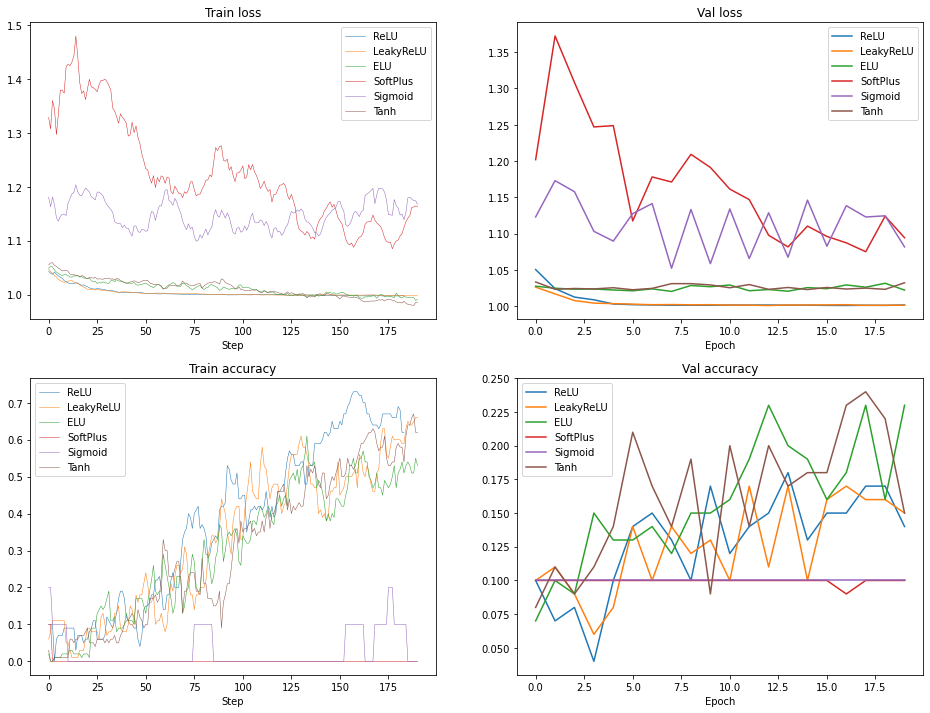

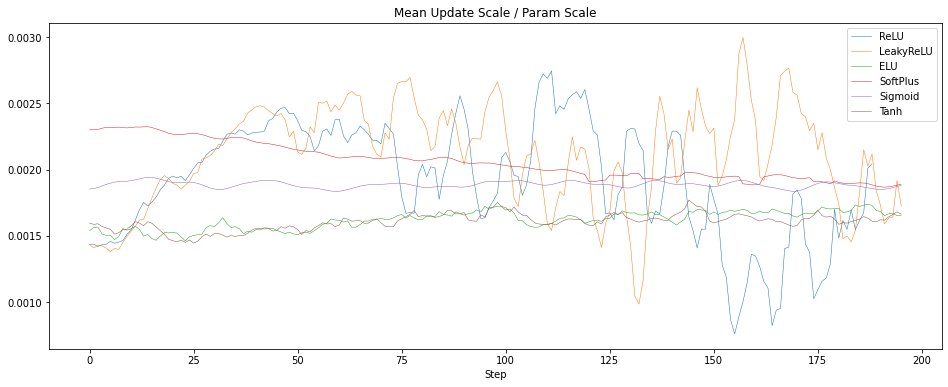

------------------------------------------------------TEST ACCURACY------------------------------------------------------
ReLU: 0.18
LeakyReLU: 0.18
ELU: 0.21
SoftPlus: 0.1
Sigmoid: 0.1
Tanh: 0.15


In [161]:
plot_results(list(train_results.values()))

As we can see the best results were obtained with $\textbf{ReLU}$, $\textbf{ELU}$ and $\textbf{ReLU}$.

For future experiments I'll use $\textbf{ELU}$ activation.

### b) In this part, I will explore the impact of regularizations on learning: $\textbf{L1}$, $\textbf{L2}$ and $\textbf{DropOut}$.

In [212]:
model_with_dropout = Sequential()
model_with_dropout.add(Linear(INPUT_SIZE, HIDDEN_SIZE*8))
model_with_dropout.add(Dropout(p=0.5))
model_with_dropout.add(ELU())
model_with_dropout.add(Linear(HIDDEN_SIZE*8, HIDDEN_SIZE*4))
model_with_dropout.add(Dropout(p=0.5))
model_with_dropout.add(ELU())
model_with_dropout.add(Linear(HIDDEN_SIZE*4, HIDDEN_SIZE*2))
model_with_dropout.add(Dropout(p=0.5))
model_with_dropout.add(ELU())
model_with_dropout.add(Linear(HIDDEN_SIZE*2, HIDDEN_SIZE))
model_with_dropout.add(Dropout(p=0.5))
model_with_dropout.add(ELU())
model_with_dropout.add(Linear(HIDDEN_SIZE, OUTPUT_SIZE))

model_without_dropout_l1 = Sequential()
model_without_dropout_l1.add(Linear(INPUT_SIZE, HIDDEN_SIZE*8))
model_without_dropout_l1.add(ELU())
model_without_dropout_l1.add(Linear(HIDDEN_SIZE*8, HIDDEN_SIZE*4))
model_without_dropout_l1.add(ELU())
model_without_dropout_l1.add(Linear(HIDDEN_SIZE*4, HIDDEN_SIZE*2))
model_without_dropout_l1.add(ELU())
model_without_dropout_l1.add(Linear(HIDDEN_SIZE*2, HIDDEN_SIZE))
model_without_dropout_l1.add(ELU())
model_without_dropout_l1.add(Linear(HIDDEN_SIZE, OUTPUT_SIZE))

model_without_dropout_l2 = Sequential()
model_without_dropout_l2.add(Linear(INPUT_SIZE, HIDDEN_SIZE*8))
model_without_dropout_l2.add(ELU())
model_without_dropout_l2.add(Linear(HIDDEN_SIZE*8, HIDDEN_SIZE*4))
model_without_dropout_l2.add(ELU())
model_without_dropout_l2.add(Linear(HIDDEN_SIZE*4, HIDDEN_SIZE*2))
model_without_dropout_l2.add(ELU())
model_without_dropout_l2.add(Linear(HIDDEN_SIZE*2, HIDDEN_SIZE))
model_without_dropout_l2.add(ELU())
model_without_dropout_l2.add(Linear(HIDDEN_SIZE, OUTPUT_SIZE))

model_without_dropout = Sequential()
model_without_dropout.add(Linear(INPUT_SIZE, HIDDEN_SIZE*8))
model_without_dropout.add(ELU())
model_without_dropout.add(Linear(HIDDEN_SIZE*8, HIDDEN_SIZE*4))
model_without_dropout.add(ELU())
model_without_dropout.add(Linear(HIDDEN_SIZE*4, HIDDEN_SIZE*2))
model_without_dropout.add(ELU())
model_without_dropout.add(Linear(HIDDEN_SIZE*2, HIDDEN_SIZE))
model_without_dropout.add(ELU())
model_without_dropout.add(Linear(HIDDEN_SIZE, OUTPUT_SIZE))

models = {
    'With DropOut': model_with_dropout,
    'Without DropOut L1': model_without_dropout_l1,
    'Without DropOut L2': model_without_dropout_l2,
    'Without Regularizations': model_without_dropout
}
model_names = ["With DropOut", "Without DropOut L1", 'Without DropOut L2', 'Without Regularizations']

In [213]:
hinge_criterion = HingeLoss()
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
np.random.seed(42)

train_results = {}

regularizations = [None, 'l1', 'l2', None]
reg_coefs = [None, 5e-3, 5e-2, None]


for regularization, model_name, reg_coef in zip(regularizations, model_names, reg_coefs):
    train_results[model_name] = train(
    models[model_name], hinge_criterion, sgm_momentum, optimizer_config,
    train_dataloader, val_dataloader, test_dataloader, model_name=model_name,
    reg_coef=reg_coef, regularization=regularization, epoch_num=50
)

100%|██████████| 50/50 [01:30<00:00,  1.82s/it]


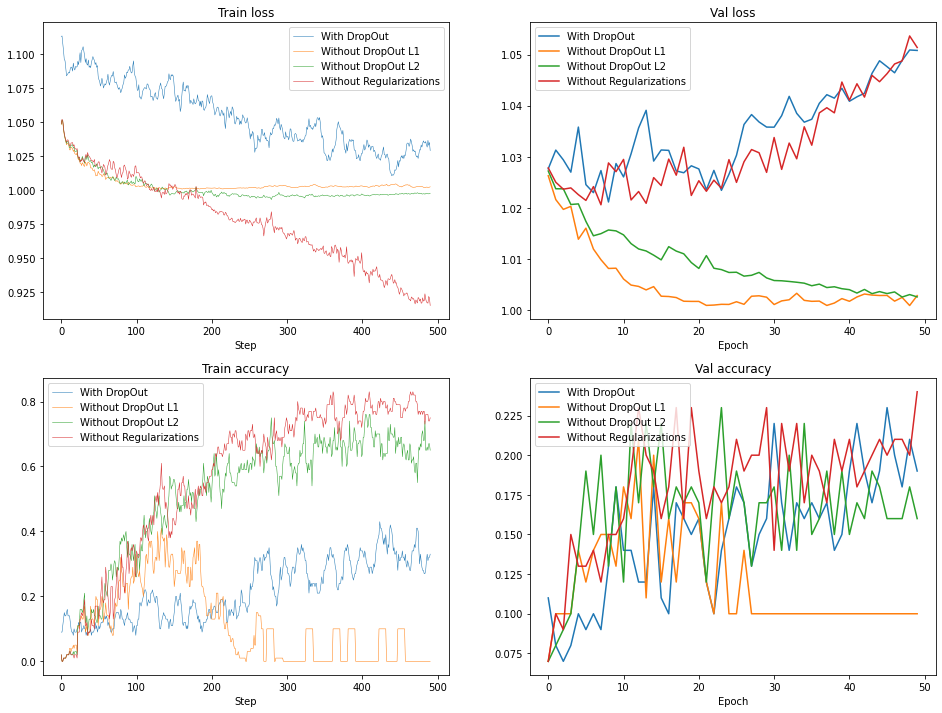

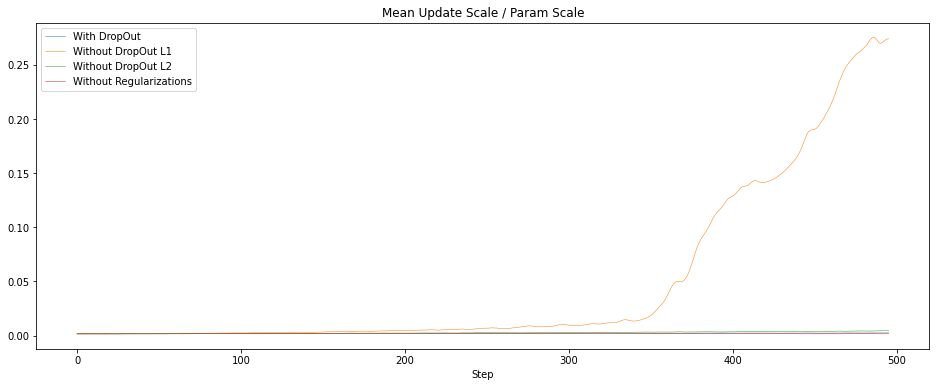

------------------------------------------------------TEST ACCURACY------------------------------------------------------
With DropOut: 0.23
Without DropOut L1: 0.1
Without DropOut L2: 0.23
Without Regularizations: 0.27


In [214]:
plot_results(list(train_results.values()))

The val loss graph shows that regularizations help the model to retrain less, but in our particular case this does not lead to a better result.

It'll be more useful for long training on bigger subset (but it's too long) and when our models contain convolutions.

Here we see that DropOut noticeably improves the results, and L1 and L2, on the contrary, spoil them.

### c) In this part, I will explore the impact of BatchNorm on learning.

In this part I dont need to show overfitting, so I'll use bigger dataset for better results.

In [263]:
X_val, Y_val = X_train_orig[0:2000], Y_train_orig[0:2000]
X_train, Y_train = X_train_orig[2000:12000], Y_train_orig[2000:12000]
X_test, Y_test = X_test_orig[0:2000], Y_test_orig[0:2000]

BATCH_SIZE = 1000
train_dataset = Cifar10Dataset(X_train, Y_train)
val_dataset = Cifar10Dataset(X_val, Y_val)
test_dataset = Cifar10Dataset(X_test, Y_test)

train_dataloader = CifarDataloader(train_dataset, BATCH_SIZE)
val_dataloader = CifarDataloader(val_dataset, BATCH_SIZE)
test_dataloader = CifarDataloader(test_dataset, batch_size=len(test_dataset))

In [264]:
model_1 = Sequential()
model_1.add(Linear(INPUT_SIZE, HIDDEN_SIZE*2))
model_1.add(BatchNormalization())
model_1.add(ELU())
model_1.add(Linear(HIDDEN_SIZE*2, HIDDEN_SIZE))
model_1.add(BatchNormalization())
model_1.add(ELU())
model_1.add(Linear(HIDDEN_SIZE, OUTPUT_SIZE))

model_2 = Sequential()
model_2.add(Linear(INPUT_SIZE, HIDDEN_SIZE))
model_2.add(BatchNormalization())
model_2.add(ELU())
model_2.add(Linear(HIDDEN_SIZE, OUTPUT_SIZE))

model_3 = Sequential()
model_3.add(Linear(INPUT_SIZE, HIDDEN_SIZE*2))
model_3.add(ELU())
model_3.add(Linear(HIDDEN_SIZE*2, HIDDEN_SIZE))
model_3.add(ELU())
model_3.add(Linear(HIDDEN_SIZE, OUTPUT_SIZE))

model_4 = Sequential()
model_4.add(Linear(INPUT_SIZE, HIDDEN_SIZE))
model_4.add(ELU())
model_4.add(Linear(HIDDEN_SIZE, OUTPUT_SIZE))

models = {
    'Big Model + BatchNorm': model_1,
    'Small Model + BatchNorm': model_2,
    'Big Model Without Batchnorm': model_3,
    'Small Model Without Batchnorm': model_4
}
model_names = [
    "Big Model + BatchNorm", 
    "Small Model + BatchNorm", 
    'Big Model Without Batchnorm',
    'Small Model Without Batchnorm']

In [265]:
hinge_criterion = HingeLoss()
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
np.random.seed(42)

train_results = {}

for model_name in model_names:
    train_results[model_name] = train(
    models[model_name], hinge_criterion, sgm_momentum, optimizer_config,
    train_dataloader, val_dataloader, test_dataloader, model_name=model_name,
    reg_coef=None, regularization=None, epoch_num=10
    )

100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


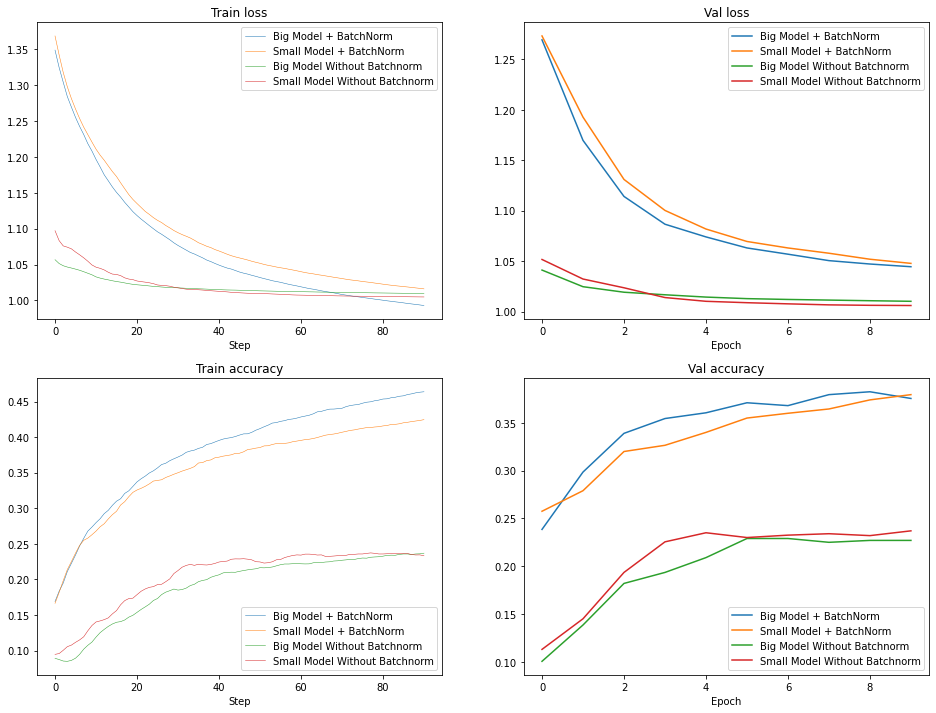

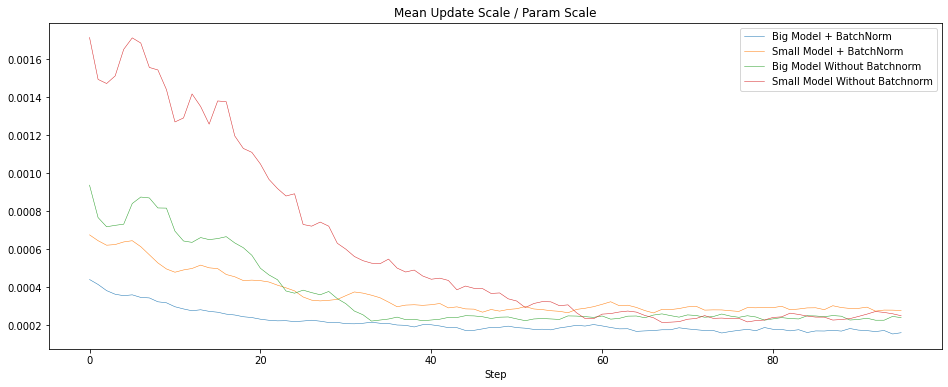

------------------------------------------------------TEST ACCURACY------------------------------------------------------
Big Model + BatchNorm: 0.3835
Small Model + BatchNorm: 0.3605
Big Model Without Batchnorm: 0.223
Small Model Without Batchnorm: 0.226


In [266]:
plot_results(list(train_results.values()))

Here we see that BatchNorm significantly improves the results, with both small and large models.

### d) In this part, I will explore the difference between training with Adam optimizer and with SGD.

In [267]:
model_1 = Sequential()
model_1.add(Linear(INPUT_SIZE, HIDDEN_SIZE))
model_1.add(BatchNormalization())
model_1.add(ELU())
model_1.add(Linear(HIDDEN_SIZE, OUTPUT_SIZE))

model_2 = Sequential()
model_2.add(Linear(INPUT_SIZE, HIDDEN_SIZE))
model_2.add(BatchNormalization())
model_2.add(ELU())
model_2.add(Linear(HIDDEN_SIZE, OUTPUT_SIZE))

models = {
    'Model with SGD': model_1,
    'Model with Adam': model_2,
}
model_names = [
    "Model with Adam", 
    "Model with SGD", 
    ]

In [268]:
hinge_criterion = HingeLoss()
optimizer_config_1 = {
    'learning_rate' : 1e-3, 
    'momentum': 0.9,
    'beta1':0.9,
    'beta2':0.99,
    'epsilon':1e-08
    }

optimizer_config_2 = {'learning_rate' : 1e-3, 'momentum': 0.0}
np.random.seed(42)

train_results = {}

optimizers = [adam_optimizer, sgm_momentum]
optimizer_configs = [optimizer_config_1, optimizer_config_2]


for optimizer, optimizer_config, model_name in zip(optimizers, optimizer_configs, model_names):
    train_results[model_name] = train(
    models[model_name], hinge_criterion, optimizer, optimizer_config,
    train_dataloader, val_dataloader, test_dataloader, model_name=model_name,
    reg_coef=None, regularization=None
    )

100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


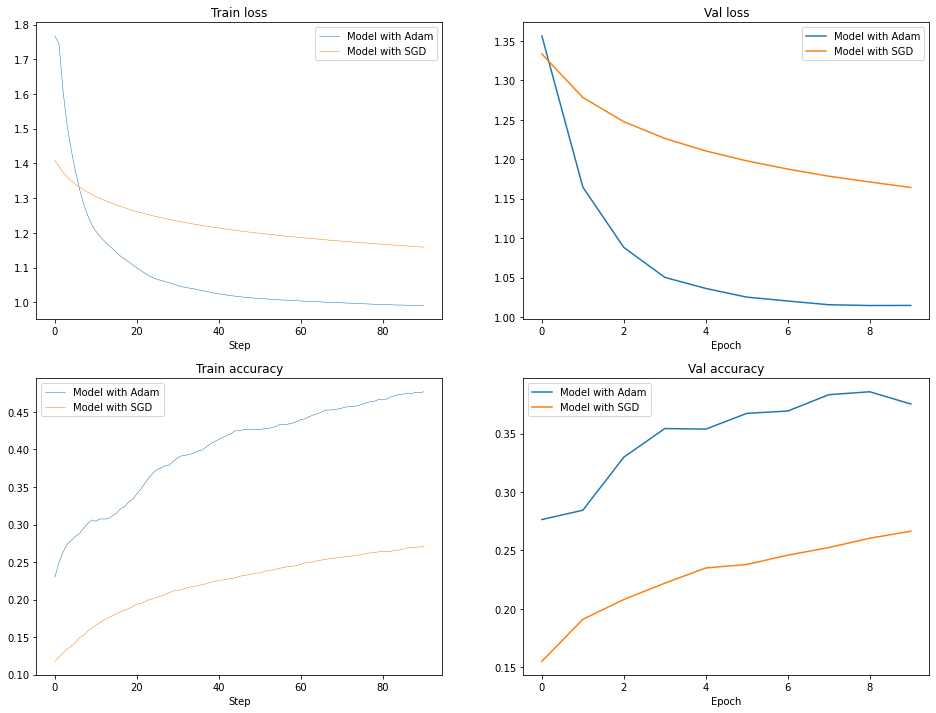

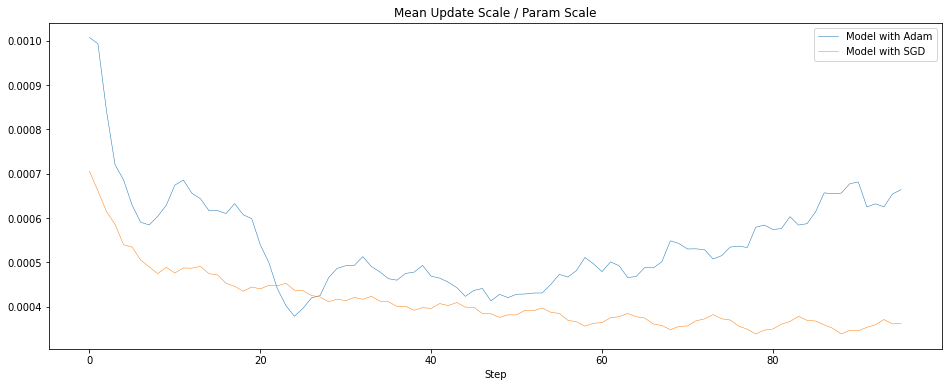

------------------------------------------------------TEST ACCURACY------------------------------------------------------
Model with Adam: 0.389
Model with SGD: 0.2585


In [269]:
plot_results(list(train_results.values()))

In this part we can clearly see that using Adam optimizer can improve results significantly.

# 3. Hyperparameters Tuning

### a) Lets compare models with different layers_num and different HIDDEN_SIZE

In [281]:
model_1 = Sequential()
model_1.add(Linear(INPUT_SIZE, HIDDEN_SIZE))
model_1.add(BatchNormalization())
model_1.add(ELU())
model_1.add(Linear(HIDDEN_SIZE, OUTPUT_SIZE))

model_2 = Sequential()
model_2.add(Linear(INPUT_SIZE, HIDDEN_SIZE*2))
model_2.add(BatchNormalization())
model_2.add(ELU())
model_2.add(Linear(HIDDEN_SIZE*2, OUTPUT_SIZE))

model_3 = Sequential()
model_3.add(Linear(INPUT_SIZE, HIDDEN_SIZE*2))
model_3.add(BatchNormalization())
model_3.add(ELU())
model_3.add(Linear(HIDDEN_SIZE*2, HIDDEN_SIZE))
model_3.add(BatchNormalization())
model_3.add(ELU())
model_3.add(Linear(HIDDEN_SIZE, OUTPUT_SIZE))

model_4 = Sequential()
model_4.add(Linear(INPUT_SIZE, HIDDEN_SIZE*4))
model_4.add(BatchNormalization())
model_4.add(ELU())
model_4.add(Linear(HIDDEN_SIZE*4, HIDDEN_SIZE*2))
model_4.add(BatchNormalization())
model_4.add(ELU())
model_4.add(Linear(HIDDEN_SIZE*2, HIDDEN_SIZE))
model_4.add(BatchNormalization())
model_4.add(ELU())
model_4.add(Linear(HIDDEN_SIZE, OUTPUT_SIZE))

models = {
    '1 hidden layer': model_1,
    '1 hidden layer, bigger hidden_size': model_2,
    '2 hidden layers': model_3,
    '3 hidden_layers': model_4,
}
model_names = [
    '1 hidden layer',
    '1 hidden layer, bigger hidden_size',
    '2 hidden layers',
    '3 hidden_layers',
    ]

In [282]:
hinge_criterion = HingeLoss()
optimizer_config = {
    'learning_rate' : 1e-3, 
    'momentum': 0.9,
    'beta1':0.9,
    'beta2':0.99,
    'epsilon':1e-08
    }

np.random.seed(42)

train_results = {}


for model_name in model_names:
    train_results[model_name] = train(
    models[model_name], hinge_criterion, adam_optimizer, optimizer_config,
    train_dataloader, val_dataloader, test_dataloader, model_name=model_name,
    reg_coef=None, regularization=None
    )

100%|██████████| 10/10 [00:51<00:00,  5.13s/it]


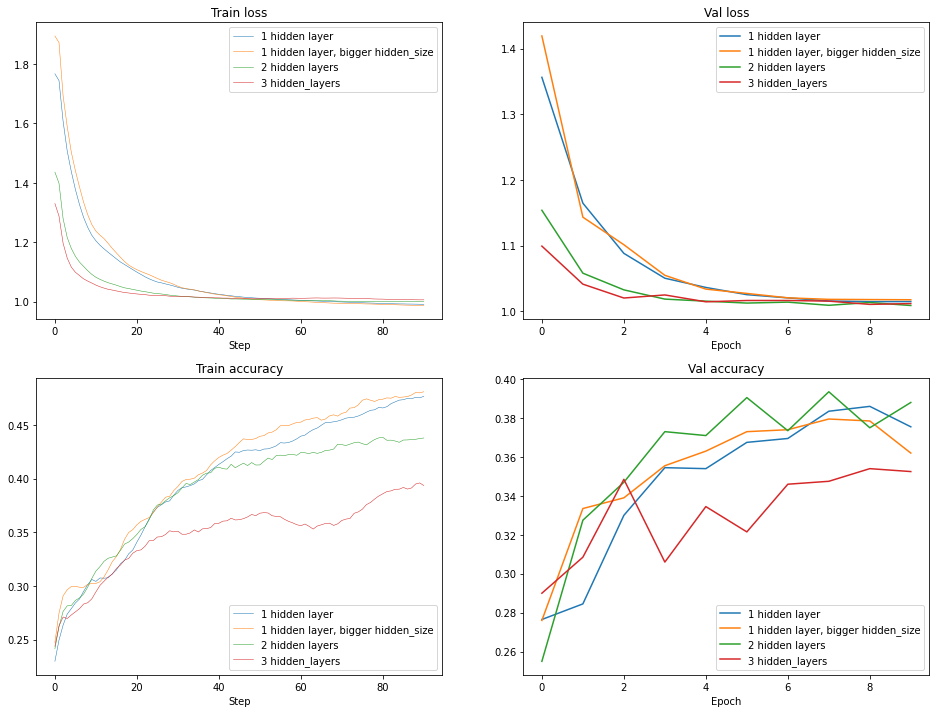

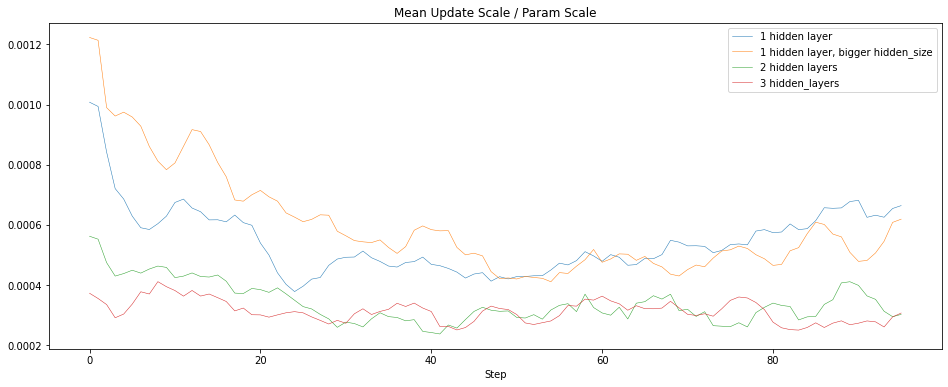

------------------------------------------------------TEST ACCURACY------------------------------------------------------
1 hidden layer: 0.389
1 hidden layer, bigger hidden_size: 0.373
2 hidden layers: 0.377
3 hidden_layers: 0.362


In [283]:
plot_results(list(train_results.values()))

In this part, the best result was obtained by the $\textbf{1 hidden layer}$ model.

Now lets try to change Dropout probability.

In [284]:
model_1 = Sequential()
model_1.add(Linear(INPUT_SIZE, HIDDEN_SIZE))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.1))
model_1.add(ELU())
model_1.add(Linear(HIDDEN_SIZE, OUTPUT_SIZE))

model_2 = Sequential()
model_2.add(Linear(INPUT_SIZE, HIDDEN_SIZE))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.2))
model_2.add(ELU())
model_2.add(Linear(HIDDEN_SIZE, OUTPUT_SIZE))

model_3 = Sequential()
model_3.add(Linear(INPUT_SIZE, HIDDEN_SIZE))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.3))
model_3.add(ELU())
model_3.add(Linear(HIDDEN_SIZE, OUTPUT_SIZE))

model_4 = Sequential()
model_4.add(Linear(INPUT_SIZE, HIDDEN_SIZE))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.4))
model_4.add(ELU())
model_4.add(Linear(HIDDEN_SIZE, OUTPUT_SIZE))

model_5 = Sequential()
model_5.add(Linear(INPUT_SIZE, HIDDEN_SIZE))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.5))
model_5.add(ELU())
model_5.add(Linear(HIDDEN_SIZE, OUTPUT_SIZE))

model_6 = Sequential()
model_6.add(Linear(INPUT_SIZE, HIDDEN_SIZE))
model_6.add(BatchNormalization())
model_6.add(Dropout(0.6))
model_6.add(ELU())
model_6.add(Linear(HIDDEN_SIZE, OUTPUT_SIZE))

model_7 = Sequential()
model_7.add(Linear(INPUT_SIZE, HIDDEN_SIZE))
model_7.add(BatchNormalization())
model_7.add(ELU())
model_7.add(Linear(HIDDEN_SIZE, OUTPUT_SIZE))

models = {
    'Dropout 0.1': model_1,
    'Dropout 0.2': model_2,
    'Dropout 0.3': model_3,
    'Dropout 0.4': model_4,
    'Dropout 0.5': model_5,
    'Dropout 0.6': model_6,
    'Without Dropout': model_7
}
model_names = [
    'Dropout 0.1',
    'Dropout 0.2',
    'Dropout 0.3',
    'Dropout 0.4',
    'Dropout 0.5',
    'Dropout 0.6',
    'Without Dropout'
    ]

In [285]:
hinge_criterion = HingeLoss()
optimizer_config = {
    'learning_rate' : 1e-3, 
    'momentum': 0.9,
    'beta1':0.9,
    'beta2':0.99,
    'epsilon':1e-08
    }

np.random.seed(42)

train_results = {}


for model_name in model_names:
    train_results[model_name] = train(
    models[model_name], hinge_criterion, adam_optimizer, optimizer_config,
    train_dataloader, val_dataloader, test_dataloader, model_name=model_name,
    reg_coef=None, regularization=None
    )

100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


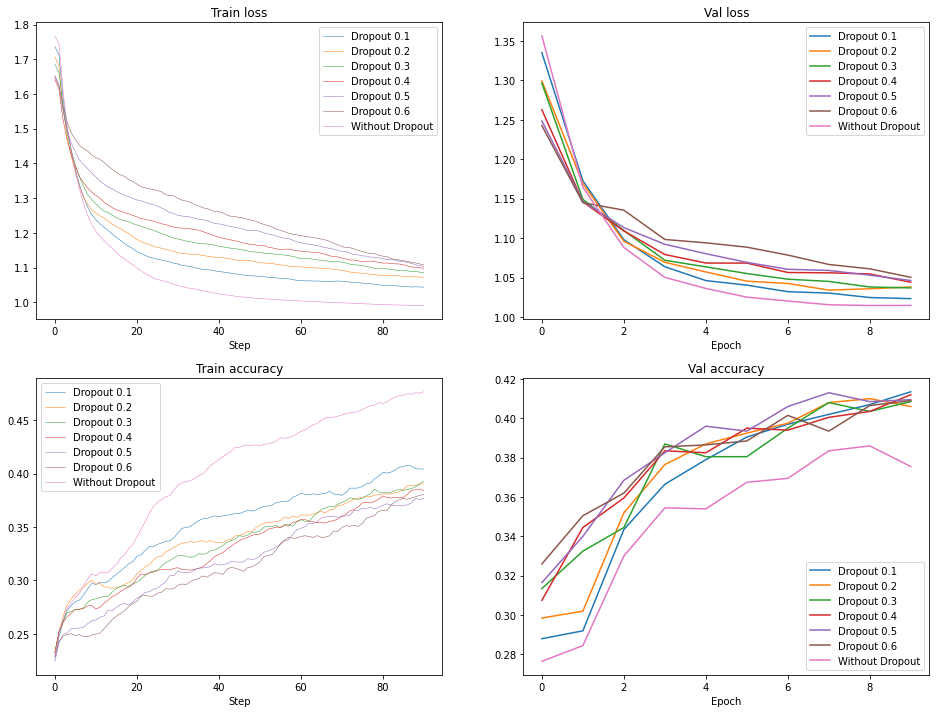

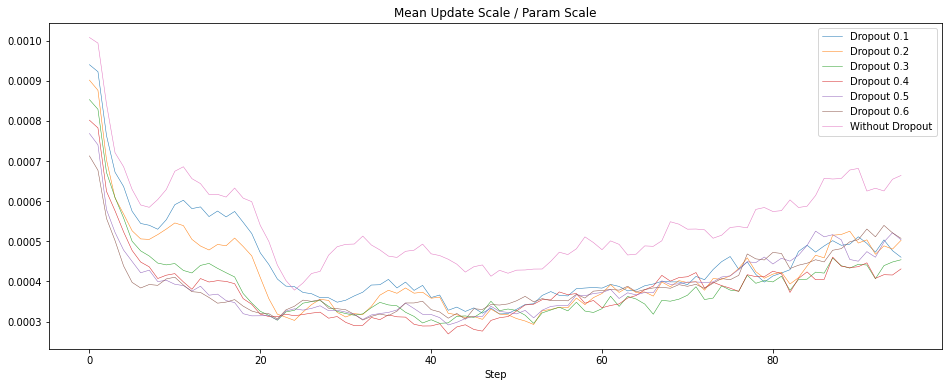

------------------------------------------------------TEST ACCURACY------------------------------------------------------
Dropout 0.1: 0.414
Dropout 0.2: 0.418
Dropout 0.3: 0.415
Dropout 0.4: 0.4215
Dropout 0.5: 0.4035
Dropout 0.6: 0.4095
Without Dropout: 0.389


In [286]:
plot_results(list(train_results.values()))

In this part, the best result was obtained by the model with $\textbf{Dropout = 0.4}$

Now lets try to change Batchsize.
Firstly, I'll use the same epoch size for each experiment, so each model will be learned on the same volume of data, but updates num will be different for different batch sizes.

In [288]:
model_1 = Sequential()
model_1.add(Linear(INPUT_SIZE, HIDDEN_SIZE))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.4))
model_1.add(ELU())
model_1.add(Linear(HIDDEN_SIZE, OUTPUT_SIZE))

model_2 = deepcopy(model_1)
model_3 = deepcopy(model_1)
model_4 = deepcopy(model_1)

train_dataloader_100 = CifarDataloader(train_dataset, batch_size=100)

train_dataloader_1000 = CifarDataloader(train_dataset, batch_size=1000)

train_dataloader_5000 = CifarDataloader(train_dataset, batch_size=5000)

train_dataloader_10000 = CifarDataloader(train_dataset, batch_size=10000)

train_dataloaders = [
    train_dataloader_100,
    train_dataloader_1000,
    train_dataloader_5000,
    train_dataloader_10000
]

models = {
    'Batchsize = 100': model_1,
    'Batchsize = 1000': model_2,
    'Batchsize = 5000': model_3,
    'Batchsize = 10000': model_4,
}
model_names = [
    'Batchsize = 100',
    'Batchsize = 1000',
    'Batchsize = 5000',
    'Batchsize = 10000'
    ]

In [289]:
hinge_criterion = HingeLoss()
optimizer_config = {
    'learning_rate' : 1e-3, 
    'momentum': 0.9,
    'beta1':0.9,
    'beta2':0.99,
    'epsilon':1e-08
    }

np.random.seed(42)

train_results = {}


for model_name, train_dataloader_curr in zip(model_names, train_dataloaders):
    train_results[model_name] = train(
    models[model_name], hinge_criterion, adam_optimizer, optimizer_config,
    train_dataloader_curr, val_dataloader, test_dataloader, model_name=model_name,
    reg_coef=None, regularization=None
    )

100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


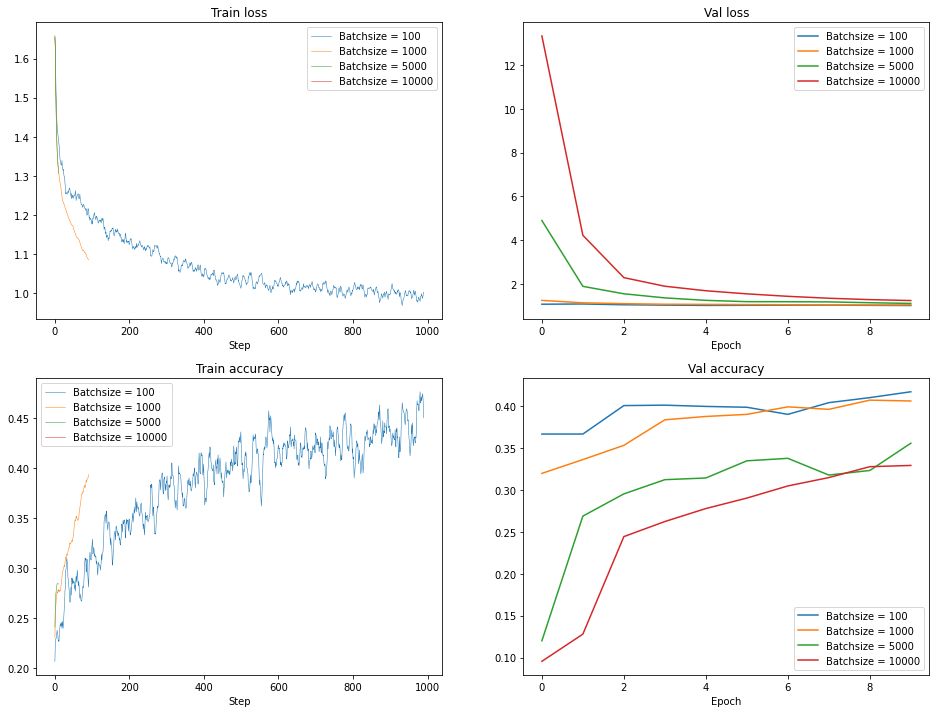

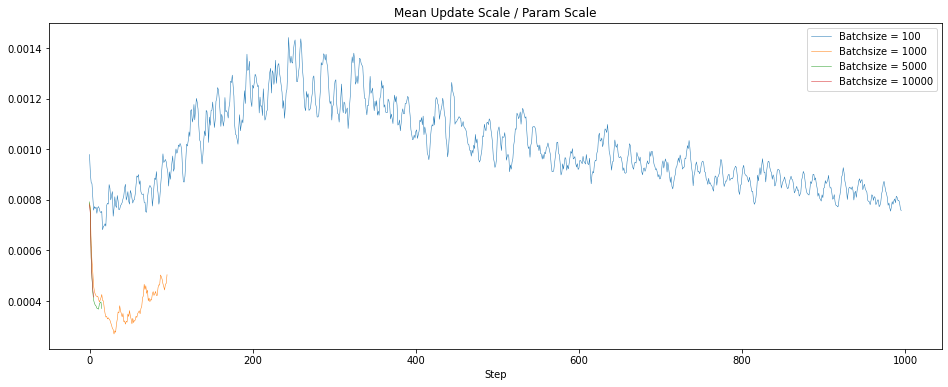

------------------------------------------------------TEST ACCURACY------------------------------------------------------
Batchsize = 100: 0.418
Batchsize = 1000: 0.4145
Batchsize = 5000: 0.3685
Batchsize = 10000: 0.323


In [290]:
plot_results(list(train_results.values()))

In this part, the best result was obtained by the model trained with $\textbf{BatchSize=100}$

This is quite logical because of different updates num, and each update in each experiment is done with the same learning rate. Lets try to increase learning rate with rescpect to batch size (bigger batch size => better gradient estimation => better direction => we can use bigger lr).

In [294]:
model_1 = Sequential()
model_1.add(Linear(INPUT_SIZE, HIDDEN_SIZE))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.4))
model_1.add(ELU())
model_1.add(Linear(HIDDEN_SIZE, OUTPUT_SIZE))

model_2 = deepcopy(model_1)
model_3 = deepcopy(model_1)
model_4 = deepcopy(model_1)

train_dataloader_100 = CifarDataloader(train_dataset, batch_size=100)

train_dataloader_1000 = CifarDataloader(train_dataset, batch_size=1000)

train_dataloader_5000 = CifarDataloader(train_dataset, batch_size=5000)

train_dataloader_10000 = CifarDataloader(train_dataset, batch_size=10000)

train_dataloaders = [
    train_dataloader_100,
    train_dataloader_1000,
    train_dataloader_5000,
    train_dataloader_10000
]

learning_rates = [1e-4, 1e-3, 5e-3, 1e-2]

models = {
    'Batchsize = 100': model_1,
    'Batchsize = 1000': model_2,
    'Batchsize = 5000': model_3,
    'Batchsize = 10000': model_4,
}
model_names = [
    'Batchsize = 100',
    'Batchsize = 1000',
    'Batchsize = 5000',
    'Batchsize = 10000'
    ]

In [295]:
hinge_criterion = HingeLoss()
optimizer_config = {
    'learning_rate' : 1e-3, 
    'momentum': 0.9,
    'beta1':0.9,
    'beta2':0.99,
    'epsilon':1e-08
    }

np.random.seed(42)

train_results = {}


for model_name, train_dataloader_curr, lr in zip(model_names, train_dataloaders, learning_rates):
    optimizer_config['learning_rate'] = lr
    train_results[model_name] = train(
    models[model_name], hinge_criterion, adam_optimizer, optimizer_config,
    train_dataloader_curr, val_dataloader, test_dataloader, model_name=model_name,
    reg_coef=None, regularization=None
    )

100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


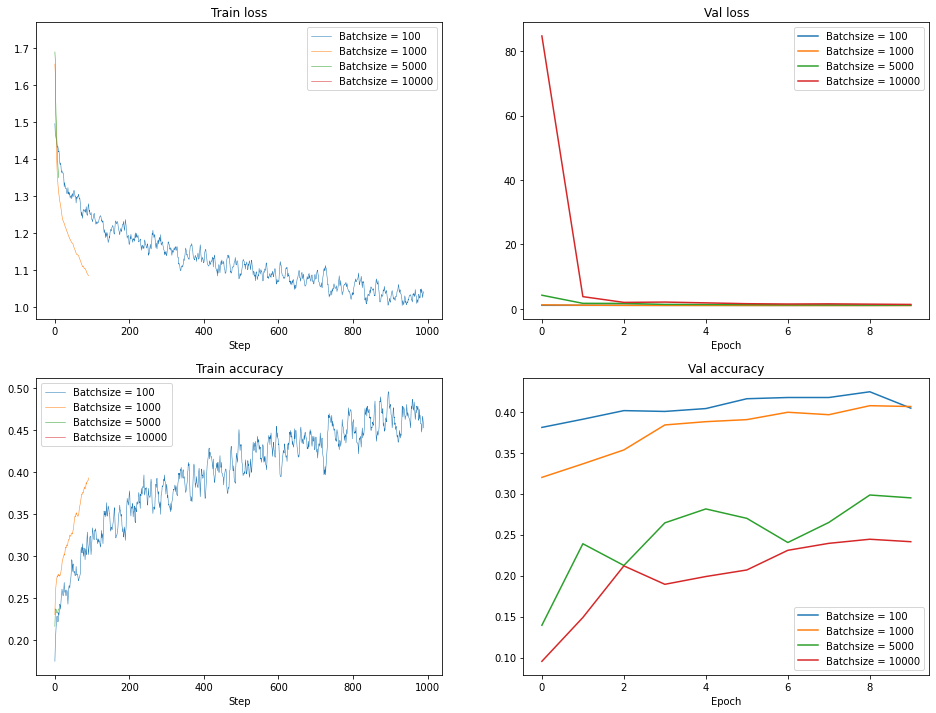

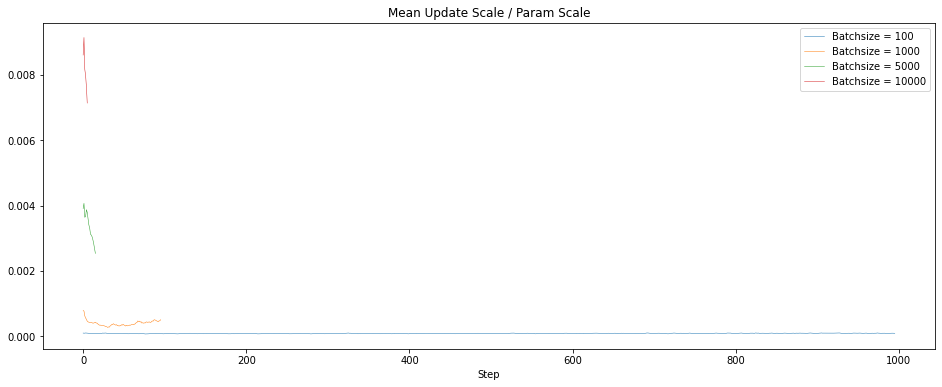

------------------------------------------------------TEST ACCURACY------------------------------------------------------
Batchsize = 100: 0.41
Batchsize = 1000: 0.4145
Batchsize = 5000: 0.3145
Batchsize = 10000: 0.256


In [296]:
plot_results(list(train_results.values()))

We got the similar result again. Of course, we can use the same learning rate and the same updates num (that leds to different epoch num) for each experiment, but in this case the effective data volume will be different and it's obviously that, for example 100k updates with batch_size = 100 would be better than 100k updates with batch_size = 10, but the first example is much more computationally expensive.

Just today I got acquainted with a new activation function (https://arxiv.org/pdf/1710.05941v1.pdf), I want to try it.

In [305]:
model_1 = Sequential()
model_1.add(Linear(INPUT_SIZE, HIDDEN_SIZE))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.4))
model_1.add(ELU())
model_1.add(Linear(HIDDEN_SIZE, OUTPUT_SIZE))

model_2 = Sequential()
model_2.add(Linear(INPUT_SIZE, HIDDEN_SIZE))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.4))
model_2.add(Swish())
model_2.add(Linear(HIDDEN_SIZE, OUTPUT_SIZE))

models = {
    'ELU': model_1,
    'Swish': model_2,
}
model_names = [
    'ELU',
    'Swish'
    ]

In [306]:
hinge_criterion = HingeLoss()
optimizer_config = {
    'learning_rate' : 1e-3, 
    'momentum': 0.9,
    'beta1':0.9,
    'beta2':0.99,
    'epsilon':1e-08
    }

np.random.seed(42)

train_results = {}

for model_name in model_names:
    train_results[model_name] = train(
    models[model_name], hinge_criterion, adam_optimizer, optimizer_config,
    train_dataloader, val_dataloader, test_dataloader, model_name=model_name,
    reg_coef=None, regularization=None
    )

100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


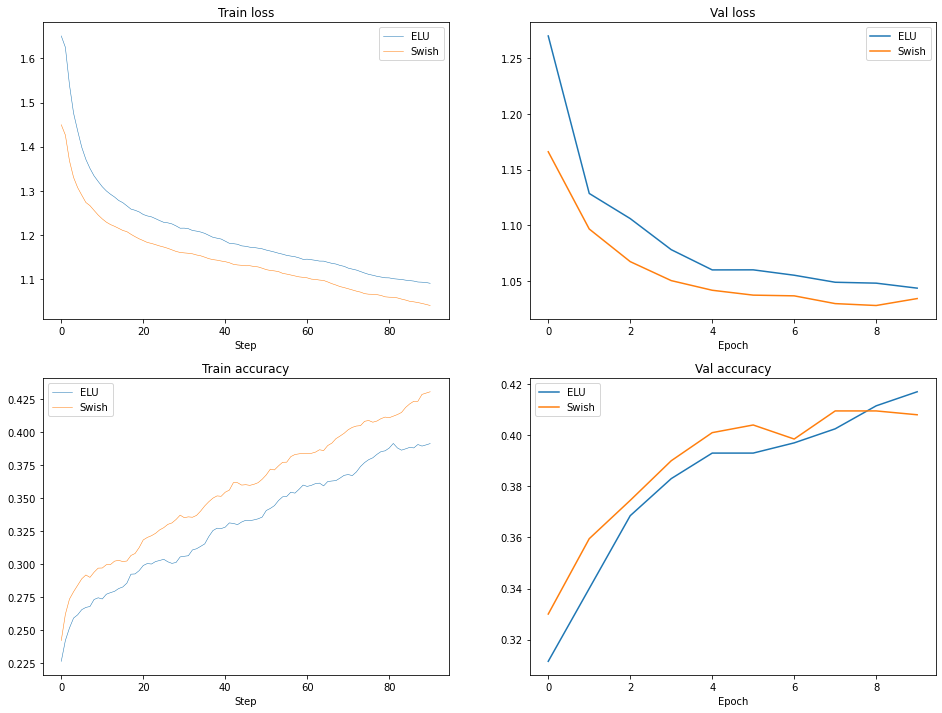

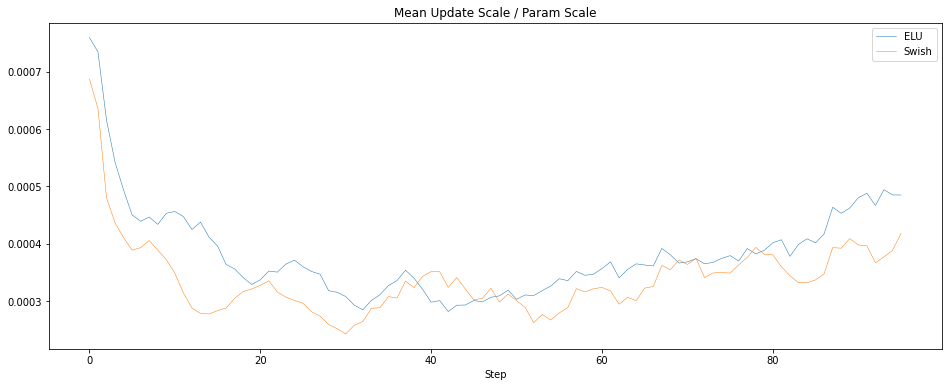

------------------------------------------------------TEST ACCURACY------------------------------------------------------
ELU: 0.4185
Swish: 0.418


In [327]:
plot_results(list(train_results.values()))

So, almost the same results(

At the end of this notebook, I want to train the best model with different learning rate at different epochs, i.e. use lr scheduler.

In [337]:
model = Sequential()
model.add(Linear(INPUT_SIZE, HIDDEN_SIZE))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(ELU())
model.add(Linear(HIDDEN_SIZE, OUTPUT_SIZE))

lr_epochs = np.concatenate([
    np.ones(10) * 1e-2,
    np.ones(10) * 1e-3,
])

In [338]:
hinge_criterion = HingeLoss()
optimizer_config = {
    'learning_rate' : 1e-3, 
    'momentum': 0.9,
    'beta1':0.95,
    'beta2':0.999,
    'epsilon':1e-08
    }

np.random.seed(42)

train_result = train(
    model, hinge_criterion, adam_optimizer, optimizer_config,
    train_dataloader, val_dataloader, test_dataloader, model_name='The only model',
    reg_coef=None, regularization=None, epoch_lrs=lr_epochs, epoch_num=20
)

100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


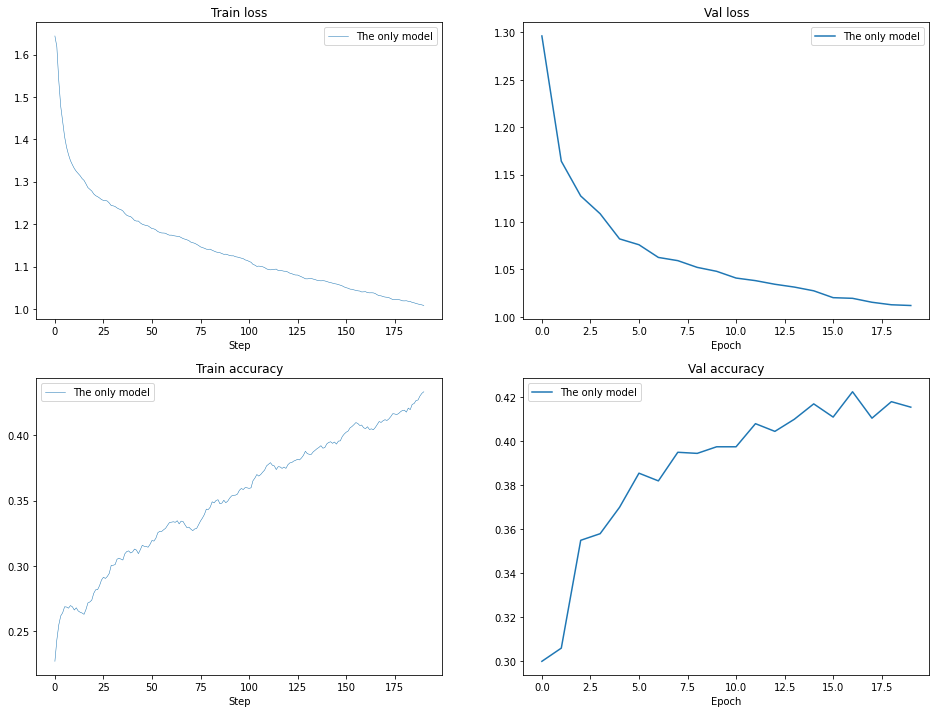

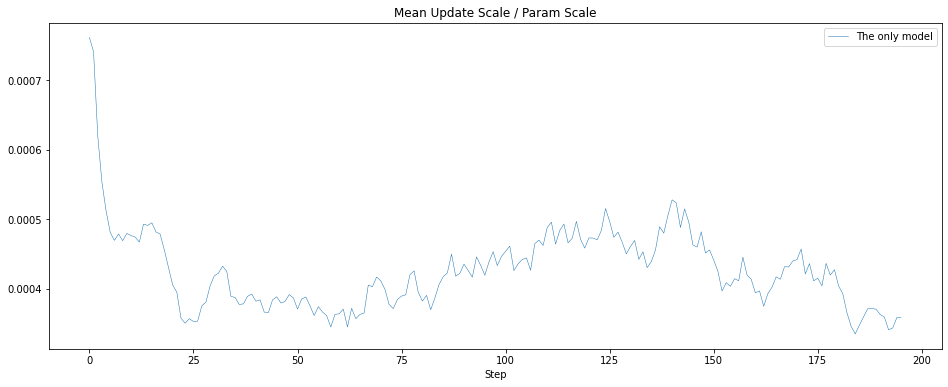

------------------------------------------------------TEST ACCURACY------------------------------------------------------
The only model: 0.4055


In [339]:
plot_results([train_result])